# Hierarchical Bayesian Model for ToM 

This notebook will be used to development the dirichlet process ToM model for dynamic goal discovery. 

### Steps 
1. Create the simulator and generate paths for 8 agents (1 agent per species)
2. Parse the data to be ready for input
3. Describe the model with PYMC
4. Test the model 

In [3]:
import numpy as np
import pymc as pm
import networkx as nx
import matplotlib.pyplot as plt


In [4]:
import sys
import os
# Adjust this path as needed to point to your project root
sys.path.append(os.path.abspath(".."))

In [5]:
def plot_goal_distribution(goal_distribution):
    """
    Plot the goal distribution as a bar plot.

    Parameters
    ----------
    goal_distribution : dict
        Dictionary mapping candidate goal IDs to probability values.
    """
    # Extract goal IDs and probabilities, converting to floats if needed.
    goals = list(goal_distribution.keys())
    probs = [float(goal_distribution[g]) for g in goals]
    
    # Create the bar plot.
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(goals)), probs, tick_label=[str(g) for g in goals])
    plt.xlabel("Candidate Goal IDs")
    plt.ylabel("Probability")
    plt.title("Posterior Distribution over Candidate Goals")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [6]:
from real_world_src.environment.campus_env import CampusEnvironment
from real_world_src.agents.agent_factory import AgentFactory
from real_world_src.simulation.simulator import Simulator
from real_world_src.utils.run_manager import RunManager

### Step 1

Started new simulation run #17
All visualizations will be saved to: /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_17_20250416_150047
Loading map data for University of California, San Diego, La Jolla, CA, USA...
Environment loaded with 3108 nodes and 8646 edges
  Added agent: ShortestPath_1
  Added agent: RandomWalk_1
  Added agent: Landmark_1
  Added agent: Social_1
  Added agent: Explorer_1
  Added agent: ObstacleAvoider_1
  Added agent: Scared_1
  Added agent: Risky_1
Saving animation to /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_17_20250416_150047/animations/campus_navigation.gif...
Reached maximum steps (1000). Not all agents reached their goals.
Animation saved successfully to /Users/nigeldoering/Desktop/Research/Dissertation/Theory of Mind/Theory-of-mind/notebooks/visuals/run_17_20250416_150047/animations/campus_navigation.gif


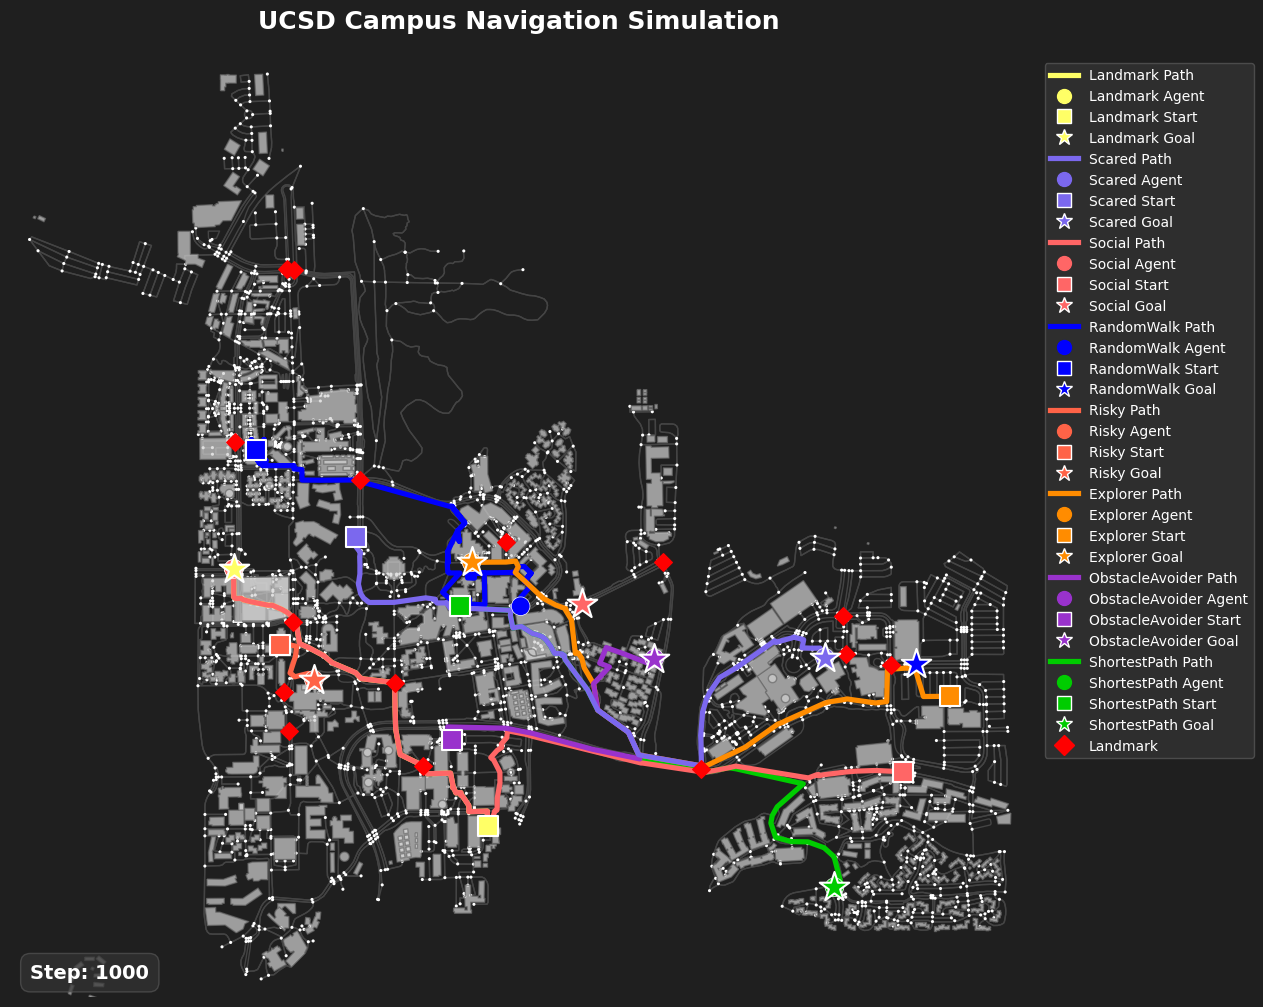

In [7]:
# Create a run manager
run_manager = RunManager('visuals')
run_dir = run_manager.start_new_run()

# Initialize campus environment
campus = CampusEnvironment()

# Specify agent populations
agent_populations = {
    "shortest": 1,  # 2 shortest path agents
    "random": 1,    # 2 random walk agents
    "landmark": 1,  # 2 landmark-based agents
    "social": 1,    # 2 social agents
    "explorer": 1,  # 2 explorer agents
    "obstacle": 1,  # 2 obstacle-avoiding agents
    "scared": 1,    # 2 scared agents
    "risky": 1      # 2 risky agents
}

# Create agents
agents = AgentFactory.populate_environment(campus, agent_populations)

# Create simulator and run
simulator = Simulator(campus, run_manager=run_manager)
simulator.run_simulation(
    max_steps=1000,
    animate=True,
    save_animation=True
)

### Step 2

In [8]:
# Not sure how to format yet

### Step 3

In [9]:
import pymc as pm

In [10]:
# Extract the goal nodes
goal_nodes = []
for agent in agents:
    goal_nodes.append(agent.goal_node)

In [11]:
# 1. collect all nodes (in a reproducible order)
nodes = list(campus.G_undirected.nodes())
node_index = {n:i for i,n in enumerate(nodes)}

# 2. run all‑pairs shortest‑paths once
lengths = dict(nx.all_pairs_shortest_path_length(campus.G_undirected))
#    lengths[u] is itself a dict mapping v→distance(u,v)

# 3. build the distance array to each of your 8 candidate goals
K = len(goal_nodes)        # e.g. 8
dist = np.zeros((len(nodes), K), dtype=float)

for k, g in enumerate(goal_nodes):
    for u, u_dists in lengths.items():
        i = node_index[u]
        # if g isn't reachable, you can set to a large number or np.inf
        dist[i, k] = u_dists.get(g, np.inf)

In [12]:
# --- 0. Precompute / load your data structures ---
# agents: list of objects, each has `id` and `path` (a list of node IDs)
# K = 8  (number of candidate goals)
# dist: a NumPy array of shape [num_nodes, K], where dist[n, k] = shortest–path distance from node n to goal k
# campus.G: your NetworkX graph

N = len(agents)
K = 8

with pm.Model() as model:
    # --- wrap your distance matrix as a PyMC Data container ---
    dist_var = pm.Data("dist_var", dist)  
    # now dist_var is an Aesara tensor, so downstream indexing
    # with symbolic indices (like z[i]) will work

    # your other priors...
    δ = np.ones(8)
    π = pm.Dirichlet("π", a=δ)
    α = pm.Gamma("α", 2.0, 1.0, shape=N)
    z = pm.Categorical("z", p=π, shape=N)
    β = pm.HalfNormal("β", sigma=1.0)

    # loop over agents/transitions as before
    for i, agent in enumerate(agents):
        path = agent.path
        for t in range(len(path)-1):
            s_t    = path[t]
            s_next = path[t+1]
            neigh  = list(campus.G_undirected.neighbors(s_t))
            if not neigh:
                continue

            d_cur   = dist_var[s_t, z[i]]       # Get distance from current state to each goal
            # for the neighbors, turn the Python list into a constant Aesara vector:
            neigh_idx = pm.Data(f"neigh_{i}_{t}", np.array(neigh, int))
            d_neigh   = dist_var[neigh_idx, z[i]]  # vector of length len(neigh)

            logits = β * α[i] * (d_cur - d_neigh)
            obs_idx = neigh.index(s_next)

            pm.Categorical(
                name=f"like_agent{i}_step{t}", 
                logit_p=logits, 
                observed=obs_idx
            )



In [15]:
pm.model_to_graphviz(model)

In [13]:
with model:
    trace = pm.sample(draws=1000, tune=1000, chains=2, target_accept=0.9)


/Users/nigeldoering/miniconda3/envs/tom/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:1023: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(



You can find the C code in this temporary file: /var/folders/38/k8ptv94x02v3qc6vywd5sfv40000gn/T/pytensor_compilation_error_vaox8luk


CompileError: Compilation failed (return status=1):
/usr/bin/clang++ -dynamiclib -g -O3 -fno-math-errno -Wno-unused-label -Wno-unused-variable -Wno-write-strings -Wno-c++11-narrowing -fno-exceptions -fno-unwind-tables -fno-asynchronous-unwind-tables -DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION -fPIC -undefined dynamic_lookup -I/Users/nigeldoering/miniconda3/envs/tom/lib/python3.12/site-packages/numpy/_core/include -I/Users/nigeldoering/miniconda3/envs/tom/include/python3.12 -I/Users/nigeldoering/miniconda3/envs/tom/lib/python3.12/site-packages/pytensor/link/c/c_code -L/Users/nigeldoering/miniconda3/envs/tom/lib -fvisibility=hidden -o /Users/nigeldoering/.pytensor/compiledir_macOS-14.6.1-arm64-arm-64bit-arm-3.12.0-64/tmp9g2gn9jr/mac92e2dc2a4a0d220d41c89865443fab0d8099b202bfd594f543e7e7a19699c0.so /Users/nigeldoering/.pytensor/compiledir_macOS-14.6.1-arm64-arm-64bit-arm-3.12.0-64/tmp9g2gn9jr/mod.cpp
/Users/nigeldoering/.pytensor/compiledir_macOS-14.6.1-arm64-arm-64bit-arm-3.12.0-64/tmp9g2gn9jr/mod.cpp:25501:32: fatal error: bracket nesting level exceeded maximum of 256
 25501 |         if (!PyErr_Occurred()) {
       |                                ^
/Users/nigeldoering/.pytensor/compiledir_macOS-14.6.1-arm64-arm-64bit-arm-3.12.0-64/tmp9g2gn9jr/mod.cpp:25501:32: note: use -fbracket-depth=N to increase maximum nesting level
1 error generated.

Apply node that caused the error: Add(2.0794415416798357, Switch.0, Mul.0, Sum{axes=None}.0, Sum{axes=None}.0, Switch.0, Subtensor{i}.0, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1, 0 <= p <=1, sum(p) = 1)
Toposort index: 13453
Inputs types: [TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=()), TensorType(float64, shape=())]

HINT: Use a linker other than the C linker to print the inputs' shapes and strides.
HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
# Extract posterior samples of z (shape: n_samples × N)
z_samples = trace.get_values('z', combine=True)

# Select an agent (by index in `agents`) to inspect:
i_test = 0
counts = np.bincount(z_samples[:, i_test], minlength=K)
posterior_prob = counts / counts.sum()

print(f"Posterior goal distribution for agent {i_test}:")
for k, p in enumerate(posterior_prob):
    print(f"  Goal {k}: {p:.3f}")